# Time as a Decision Variable

Time can be an important decision variable in process optimization. Questions like "when will the concentration reach peak value?", or "how fast can this separation be done?", or "when will the temperature reach the target value?" are situations where the time is a decision variable, or even the primary objective, for optimization. 

The purpose of this notebook is to demonstrate how rescaling time can be useful in problems like these. This is not a universal solution for all problems involving time, but it definitely should be part of your modeling toolkit.

The example is a model for an isothermal fed-batch reactor with the liquid phase reactions

$$A \stackrel{k_1 = 1/hr}{\longrightarrow} B \stackrel{k_2 = 3/hr}{\longrightarrow} C $$

$A$ is the feed reactant, $B$ is the desired product, and $C$ is an undesired by-product. The feed with volumetric flowrate of $q(t)$ and concentration $C_{A,f} = 2$ mol/liter. The initial concentration is also 2 mol/liter and the initial volume is 500 liters. The total volume of the tank is 1,000 liters. The control objective is control the feed rate to achieve as much product as possible.

$$\begin{align*}
\frac{dVC_A}{dt} & = -  Vk_1 C_A + q(t) C_{A,f} \\
\frac{dVC_B}{dt} & = V k_1 C_A - V k_2 C_B \\
\frac{dV}{dt} & = q(t)
\end{align*}$$

For integration purposes

$$\begin{align*}
C_A \frac{dV}{dt} + V \frac{dC_A}{dt} & = -  Vk_1 C_A + q(t) C_{A,f} \\
C_B \frac{dV}{dt} + V \frac{dC_B}{dt} & = V k_1 C_A - V k_2 C_B \\
\frac{dV}{dt} & = q(t)
\end{align*}$$

or

$$\begin{align*}
V \frac{dC_A}{dt} & = -  Vk_1 C_A + q(t) (C_{A,f} - C_A) \\
V \frac{dC_B}{dt} & = V k_1 C_A - V k_2 C_B - q(t)C_B\\
\frac{dV}{dt} & = q(t)
\end{align*}$$


In [64]:
import pyomo.environ as pyo
import pyomo.dae as dae
import matplotlib.pyplot as plt


# rate parameters
k1 =  1
k2 = 3

# feed concentration
cA_feed = 2.0

# initial conditions
V_initial = 500
cA_initial = 2.0
cB_initial = 0.0

# time horizon
tf = 5

# inlet flowrate
q = (1000 - V_initial)/tf

# pyomo modeling
m = pyo.ConcreteModel()

m.t = dae.ContinuousSet(bounds=(0, tf))
m.cA = pyo.Var(m.t, domain=pyo.NonNegativeReals)
m.cB = pyo.Var(m.t, domain=pyo.NonNegativeReals)
m.V = pyo.Var(m.t, bounds=(V_initial, 1000))

m.dcAdt = dae.DerivativeVar(m.cA)
m.dcBdt = dae.DerivativeVar(m.cB)
m.dVdt = dae.DerivativeVar(m.V)

@m.Constraint(m.t)
def ode_cA(m, t):
    return m.V[t] * m.dcAdt[t] == - m.V[t] * k1 * m.cA[t] + q * (cA_feed - m.cA[t])

@m.Constraint(m.t)
def ode_cB(m, t):
    return m.V[t] * m.dcBdt[t] == m.V[t] * k1 * m.cA[t] - m.V[t] * k2 * m.cB[t] - q * m.cB[t]

@m.Constraint(m.t)
def ode_V(m, t):
    return m.dVdt[t] == q

m.cA[0].fix(cA_initial)
m.cB[0].fix(cB_initial)
m.V[0].fix(V_initial)

pyo.TransformationFactory('dae.finite_difference').apply_to(m, nfe=100, scheme='FORWARD')
pyo.SolverFactory('ipopt').solve(m)



{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 603, 'Number of variables': 603, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.13.4\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.7883000373840332}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

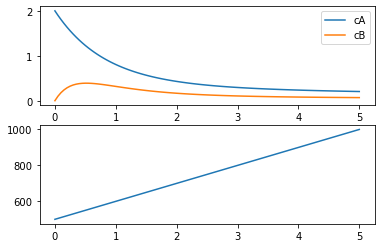

In [65]:

fig, ax = plt.subplots(2, 1)

ax[0].plot(m.t, [m.cA[t].value for t in m.t], label="cA")
ax[0].plot(m.t, [m.cB[t].value for t in m.t], label="cB")
ax[0].legend()

ax[1].plot(m.t, [m.V[t].value for t in m.t])


## What is the objective?

Text(0.5, 0, 'Time')

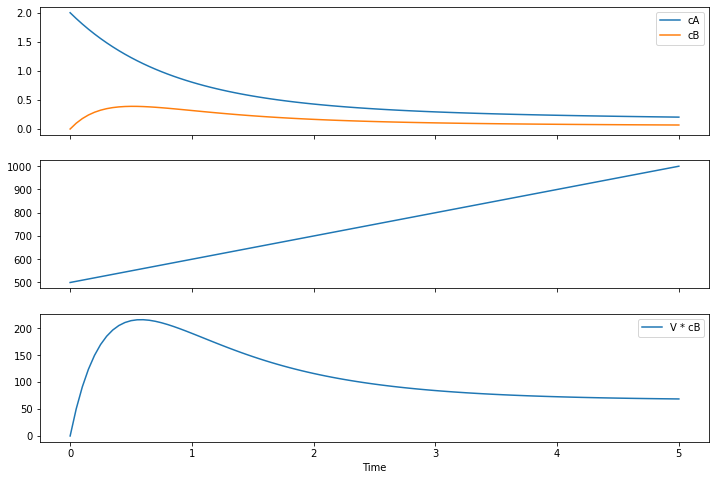

In [66]:

fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

ax[0].plot(m.t, [m.cA[t].value for t in m.t], label="cA")
ax[0].plot(m.t, [m.cB[t].value for t in m.t], label="cB")
ax[0].legend()

ax[1].plot(m.t, [m.V[t].value for t in m.t])

ax[2].plot(m.t, [m.V[t].value * m.cB[t].value for t in m.t], label="V * cB")
ax[2].legend()
ax[2].set_xlabel('Time')


## Trial and Error

Let's guess values of $t_f$ to see if we can find a solution to our problem.

Text(0.5, 0, 'Time')

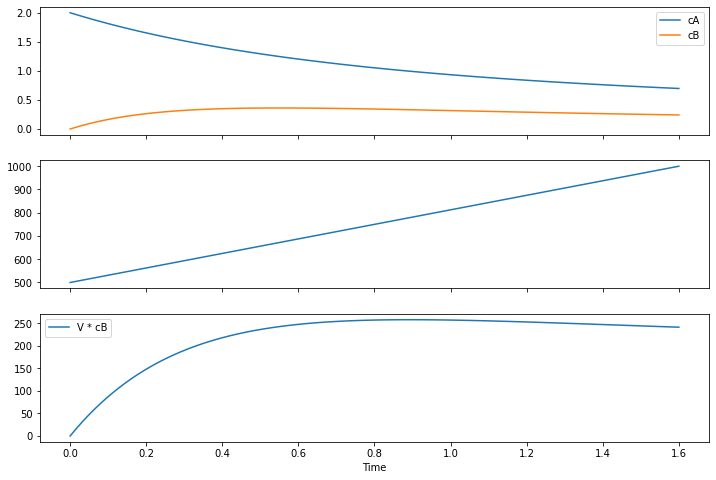

In [67]:
import pyomo.environ as pyo
import pyomo.dae as dae
import matplotlib.pyplot as plt


# rate parameters
k1 =  1
k2 = 3

# feed concentration
cA_feed = 2.0

# initial conditions
V_initial = 500
cA_initial = 2.0
cB_initial = 0.0

# time horizon
tf = 1.6

# inlet flowrate
q = (1000 - V_initial)/tf

# pyomo modeling
m = pyo.ConcreteModel()

m.t = dae.ContinuousSet(bounds=(0, tf))
m.cA = pyo.Var(m.t, domain=pyo.NonNegativeReals)
m.cB = pyo.Var(m.t, domain=pyo.NonNegativeReals)
m.V = pyo.Var(m.t, bounds=(V_initial, 1000))

m.dcAdt = dae.DerivativeVar(m.cA)
m.dcBdt = dae.DerivativeVar(m.cB)
m.dVdt = dae.DerivativeVar(m.V)

@m.Constraint(m.t)
def ode_cA(m, t):
    return m.V[t] * m.dcAdt[t] == - m.V[t] * k1 * m.cA[t] + q * (cA_feed - m.cA[t])

@m.Constraint(m.t)
def ode_cB(m, t):
    return m.V[t] * m.dcBdt[t] == m.V[t] * k1 * m.cA[t] - m.V[t] * k2 * m.cB[t] - q * m.cB[t]

@m.Constraint(m.t)
def ode_V(m, t):
    return m.dVdt[t] == q

m.cA[0].fix(cA_initial)
m.cB[0].fix(cB_initial)
m.V[0].fix(V_initial)

pyo.TransformationFactory('dae.finite_difference').apply_to(m, nfe=100, scheme='FORWARD')
pyo.SolverFactory('ipopt').solve(m)


fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

ax[0].plot(m.t, [m.cA[t].value for t in m.t], label="cA")
ax[0].plot(m.t, [m.cB[t].value for t in m.t], label="cB")
ax[0].legend()

ax[1].plot(m.t, [m.V[t].value for t in m.t])

ax[2].plot(m.t, [m.V[t].value * m.cB[t].value for t in m.t], label="V * cB")
ax[2].legend()
ax[2].set_xlabel('Time')



## Rescaling Time

$$q(t) = \frac{V_{final} - V_{initial}}{t_f}$$

$$\begin{align*}
V \frac{dC_A}{dt} & = -  Vk_1 C_A + q(t) (C_{A,f} - C_A) \\
V \frac{dC_B}{dt} & = V k_1 C_A - V k_2 C_B - q(t)C_B\\
\frac{dV}{dt} & = q(t)
\end{align*}$$


$$\begin{align*}
\frac{V}{t_f} \frac{dC_A}{d\tau} & = -  Vk_1 C_A + q(t) (C_{A,f} - C_A) \\
\frac{V}{t_f} \frac{dC_B}{dt} & = V k_1 C_A - V k_2 C_B - q(t)C_B\\
\frac{1}{t_f}\frac{dV}{d\tau} & = q(t)
\end{align*}$$

$$\begin{align*}
\frac{V}{t_f} \frac{dC_A}{d\tau} & = -  t_fVk_1 C_A + q (C_{A,f} - C_A) \\
\frac{V}{t_f} \frac{dC_B}{dt} & = V k_1 C_A - V k_2 C_B - q C_B\\
\frac{1}{t_f}\frac{dV}{d\tau} & = q \\
q & = \frac{V_{final} - V_{initial}}{t_f}
\end{align*}$$


0.6249998743596756


Text(0.5, 0, 'Time')

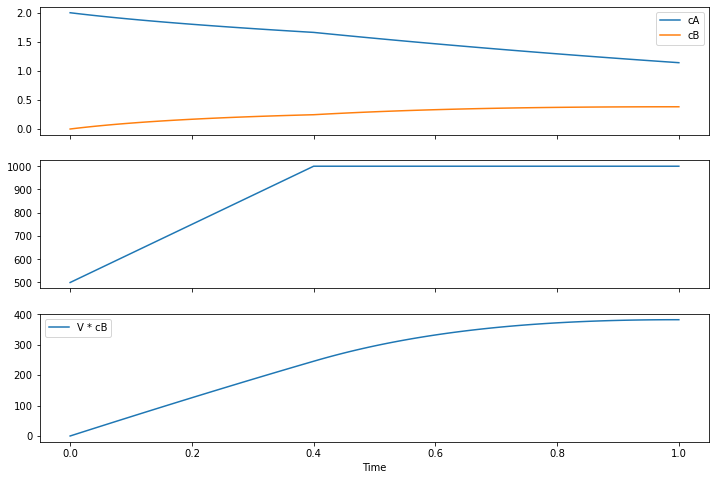

In [74]:
import pyomo.environ as pyo
import pyomo.dae as dae
import matplotlib.pyplot as plt


# rate parameters
k1 =  1
k2 = 3

# feed concentration
cA_feed = 2.0

# initial conditions
V_initial = 500
cA_initial = 2.0
cB_initial = 0.0

# final volume
V_final = 1000

# pyomo modeling
m = pyo.ConcreteModel()

m.tau = dae.ContinuousSet(bounds=(0, 1))
m.cA = pyo.Var(m.tau, domain=pyo.NonNegativeReals)
m.cB = pyo.Var(m.tau, domain=pyo.NonNegativeReals)
m.V = pyo.Var(m.tau, bounds=(V_initial, 1000))
m.tf = pyo.Var(initialize=0.5, domain=pyo.NonNegativeReals)
m.q = pyo.Var(m.tau, domain=pyo.NonNegativeReals, bounds=(0, 2000))

m.dcAdt = dae.DerivativeVar(m.cA)
m.dcBdt = dae.DerivativeVar(m.cB)
m.dVdt = dae.DerivativeVar(m.V)

@m.Constraint(m.tau)
def ode_cA(m, tau):
    return m.V[tau] * m.dcAdt[tau] / m.tf == - m.V[tau] * k1 * m.cA[tau] + m.q[tau] * (cA_feed - m.cA[tau])

@m.Constraint(m.tau)
def ode_cB(m, tau):
    return m.V[tau] * m.dcBdt[tau] / m.tf == m.V[tau] * k1 * m.cA[tau] - m.V[tau] * k2 * m.cB[tau] - m.q[tau] * m.cB[tau]

@m.Constraint(m.tau)
def ode_V(m, tau):
    return m.dVdt[tau] / m.tf == m.q[tau]

@m.Objective(sense=pyo.maximize)
def objective(m):
    return m.V[1] * m.cB[1]

m.cA[0].fix(cA_initial)
m.cB[0].fix(cB_initial)
m.V[0].fix(V_initial)

pyo.TransformationFactory('dae.finite_difference').apply_to(m, nfe=100, scheme='FORWARD')
pyo.SolverFactory('ipopt').solve(m)

print(m.tf.value)

fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

ax[0].plot(m.tau, [m.cA[tau].value for tau in m.tau], label="cA")
ax[0].plot(m.tau, [m.cB[tau].value for tau in m.tau], label="cB")
ax[0].legend()

ax[1].plot(m.tau, [m.V[tau].value for tau in m.tau])

ax[2].plot(m.tau, [m.V[tau].value * m.cB[tau].value for tau in m.tau], label="V * cB")
ax[2].legend()
ax[2].set_xlabel('Time')